<a href="https://colab.research.google.com/github/TongQM/SONAR_VLM/blob/main/sonar_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install SONAR embeddings and requirements

In [ ]:
# !pip show torch
# !pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
# !pip install sonar-space

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /opt/homebrew/anaconda3/envs/vlm/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: fairseq2n, sonar-space, torchaudio


# Mount Google drive and set work directory

In [ ]:
# import os
# from google.colab import drive

# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/sonar')
# !ls annotations/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import necessary packages

In [93]:
import json
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet50, resnet152, ResNet152_Weights, ResNet50_Weights
from torchsummary import summary

from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'mps' if torch.backends.mps.is_available() else device
print(f"Using device: {device}")

Using device: mps


### Load train and validation data

In [51]:
subset_size = 10000
train_data = json.load(open("./annotations/captions_train2017.json"))
train_data
train_data['images'] = train_data['images'][:subset_size]
val_data = json.load(open("./annotations/captions_val2017.json"))
print(f"There are {len(train_data['images'])} pictures in training data.")
print(f"There are {len(val_data['images'])} pictures in validation data.")

There are 10000 pictures in training data.
There are 5000 pictures in validation data.


In [49]:
train_data['images']

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 {'license': 4,
  'file_name': '000000522418.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 11:38:44',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'id': 522418},
 {'license': 3,
  'file_name': '000000184613.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg',
  'height': 336,
  'width': 500,
  'date_captured': '2013-11-14 12:36:29',
  'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
  'id': 184613},
 {'license': 3,
  'file_name': '000000318219.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/0

In [54]:
train_data['annotations']

[{'image_id': 203564,
  'id': 37,
  'caption': 'A bicycle replica with a clock as the front wheel.'},
 {'image_id': 322141,
  'id': 49,
  'caption': 'A room with blue walls and a white sink and door.'},
 {'image_id': 16977,
  'id': 89,
  'caption': 'A car that seems to be parked illegally behind a legally parked car'},
 {'image_id': 106140,
  'id': 98,
  'caption': 'A large passenger airplane flying through the air.'},
 {'image_id': 106140,
  'id': 101,
  'caption': 'There is a GOL plane taking off in a partly cloudy sky.'},
 {'image_id': 322141,
  'id': 109,
  'caption': 'Blue and white color scheme in a small bathroom.'},
 {'image_id': 322141,
  'id': 121,
  'caption': 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.'},
 {'image_id': 322141,
  'id': 163,
  'caption': 'A blue boat themed bathroom with a life preserver on the wall'},
 {'image_id': 203564, 'id': 181, 'caption': 'The bike has a clock as a tire.'},
 {'image_id': 16977,
  'id': 185,
  'capti

## Load text2embedding model

In [81]:
def find_annotations(image_id, annotations):
    """
    Find all the annotations for a given image ID.
    """
    return [annotation['caption'] for annotation in annotations if annotation['image_id'] == image_id]

def get_mean_embedding(image_id, t2vec_model, annotations, device):
    """
    Get the mean embedding for a given image ID.
    """
    captions = find_annotations(image_id, annotations)
    if not captions:
        return None
    embeddings = t2vec_model.predict(captions, source_lang="eng_Latn")
    mean_embedding = torch.mean(embeddings, dim=0, keepdim=True)
    return mean_embedding

t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device('cpu'),
                                           dtype=torch.float16)

mean_embedding = get_mean_embedding(251075, t2vec_model, train_data['annotations'], device)

vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=torch.device('cpu'),
                                              dtype=torch.float16)

reconstructed = vec2text_model.predict(mean_embedding, target_lang="eng_Latn", max_seq_len=512)
print(reconstructed)


['A bathroom with a sink and a toilet with a washcloth.']


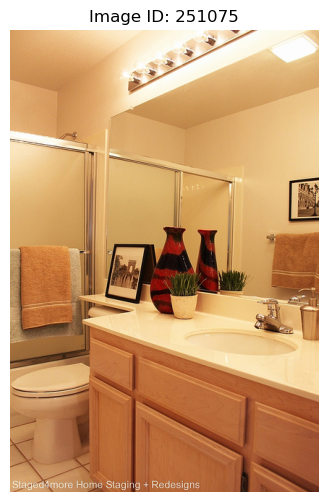

Caption 1: A bathroom with a vanity mirror toilette and kitchen sink next to a shower.
Caption 2: A bathroom with a tan sink and white toliet.
Caption 3: Bathroom with a sink, toilet, and a shower with towels on it. 
Caption 4: A bathroom with a picture and red and black vase on the vanity.
Caption 5: A bathroom is shown with a sink and toilet.
Reconstructed Caption: A bathroom with a sink and a toilet with a washcloth.


In [82]:
def visualize_image_and_captions(image_id, images, annotations):
    """
    Visualize the image and its captions.
    """
    # Find the image URL
    image_info = next((img for img in images if img['id'] == image_id), None)
    if not image_info:
        print(f"Image ID {image_id} not found.")
        return

    image_url = image_info['coco_url']

    # Fetch the image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Find captions for the current image
    captions = find_annotations(image_id, annotations)
    mean_embedding = get_mean_embedding(image_id, t2vec_model, annotations, device)
    reconstructed = vec2text_model.predict(mean_embedding, target_lang="eng_Latn", max_seq_len=512)

    # Display image and captions
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

    for i, caption in enumerate(captions):
        print(f"Caption {i+1}: {caption}")
    print(f"Reconstructed Caption: {reconstructed[0]}")

visualize_image_and_captions(251075, train_data['images'], train_data['annotations'])

In [73]:
t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device('cpu'),
                                           dtype=torch.float16)
sentences = ['A bathroom with a vanity mirror toilette and kitchen sink next to a shower.',
             'A bathroom with a tan sink and white toliet.', 
             'Bathroom with a sink, toilet, and a shower with towels on it. ', 
             'A bathroom with a picture and red and black vase on the vanity.', 'A bathroom is shown with a sink and toilet.']
embeddings = t2vec_model.predict(sentences, source_lang="eng_Latn")

vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=torch.device('cpu'),
                                              dtype=torch.float16)
reconstructed = vec2text_model.predict(embeddings, target_lang="eng_Latn", max_seq_len=512)
# max_seq_len is a keyword argument passed to the fairseq2 BeamSearchSeq2SeqGenerator.
print(reconstructed)

['A bathroom with a vanity mirror toilet and kitchen sink next to a shower.', 'A bathroom with a tan sink and white toliet.', 'Bathroom with a sink, toilet, and a shower with towels on it.', 'A bathroom with a picture and red and black vase on the vanity.', 'A bathroom is shown with a sink and toilet.']


In [38]:
train_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations'])

### Visualize sample images and their captions

Reconstructed caption: A man with a red motorcycle on a motorcycle on a dirt road.
Original captions: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']


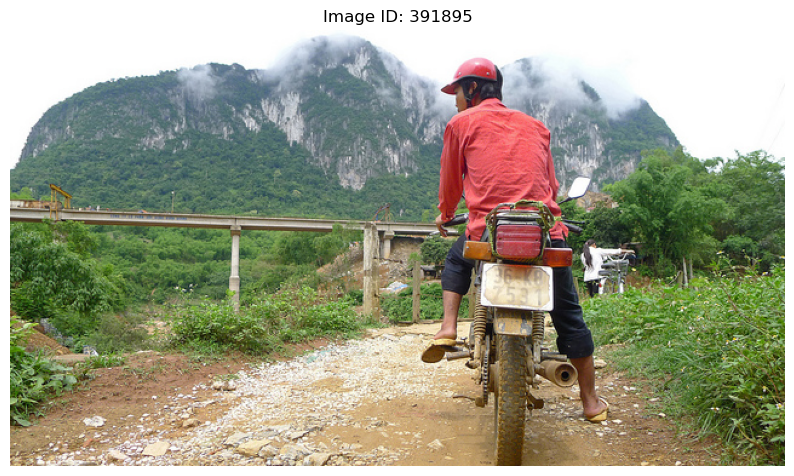

Caption 1: A man with a red helmet on a small moped on a dirt road. 
Embedding 1: tensor([ 0.0023,  0.0024, -0.0058,  ..., -0.0055,  0.0065, -0.0043],
       dtype=torch.float16)
--------------------
Caption 2: Man riding a motor bike on a dirt road on the countryside.
Embedding 2: tensor([-0.0010, -0.0089, -0.0063,  ...,  0.0010,  0.0043,  0.0052],
       dtype=torch.float16)
--------------------
Caption 3: A man riding on the back of a motorcycle.
Embedding 3: tensor([ 0.0044, -0.0020, -0.0043,  ..., -0.0046,  0.0046,  0.0019],
       dtype=torch.float16)
--------------------
Caption 4: A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
Embedding 4: tensor([ 0.0169,  0.0012,  0.0004,  ...,  0.0010,  0.0100, -0.0081],
       dtype=torch.float16)
--------------------
Caption 5: A man in a red shirt and a red hat is on a motorcycle on a hill side.
Embedding 5: tensor([-4.4942e-05, -8.3466

In [ ]:
num_images = 1
images = train_data['images'][:num_images]

for image_info in images:
    image_id = image_info['id']
    image_url = image_info['coco_url']

    # Fetch the image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Find captions for the current image
    captions = [ann['caption'] for ann in train_data['annotations'] if ann['image_id'] == image_id]
    captions = captions[:5] # get first 5 captions

    # Generate embeddings
    embeddings = t2vec_model.predict(captions, source_lang="eng_Latn")

    # Calculate the mean embedding
    mean_embedding = torch.mean(embeddings, dim=0)
    # Transforme the mean embedding to text
    reconstructed = vec2text_model.predict(mean_embedding.unsqueeze(0), target_lang="eng_Latn", max_seq_len=30)
    print(f"Reconstructed caption: {reconstructed[0]}")
    print(f"Original captions: {captions}")

    # Display image and captions with embeddings
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

    for i, caption in enumerate(captions):
        print(f"Caption {i+1}: {caption}")
        print(f"Embedding {i+1}: {embeddings[i]}")
        print("-" * 20)

### Define dataloader with SONAR embeddings as labels

In [ ]:
class ImageEmbeddingDataset(Dataset):
    """
    Dataset that returns (image_tensor, target_embedding) pairs.

    Args:
        image_paths (List[str]): Full paths to image files.
        captions_dict (Dict[str, List[str]]): Maps image stem to list of captions.
        t2vec_model: TextToEmbeddingModelPipeline instance.
        transform (callable): torchvision transforms for images.
        device (torch.device or str): where to place embeddings.
        dtype (torch.dtype): dtype for embedding tensors.
        average (bool): whether to average multiple caption embeddings.
    """
    def __init__(self, image_paths, captions_dict, t2vec_model, transform=None, device=torch.device('cpu'), dtype=torch.float32, average=True):
        self.image_paths = image_paths
        self.captions_dict = captions_dict
        self.t2vec = t2vec_model
        self.transform = transform or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.device = device
        self.dtype = dtype
        self.average = average

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess image
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        x = self.transform(img)

        # Generate or lookup text embeddings
        stem = os.path.splitext(os.path.basename(img_path))[0]
        captions = self.captions_dict[stem]
        # t2vec_model.predict returns a list/np array of shape (num_caps, dim)
        embeds = self.t2vec.predict(captions)
        y = torch.tensor(embeds, device=self.device, dtype=self.dtype)

        # Optionally average multiple caption embeddings
        if self.average:
            y = y.mean(dim=0)
        return x, y
    
train_dataset = ImageEmbeddingDataset(
    image_paths=[os.path.join('./train2017', img['file_name']) for img in train_data['images']],
    captions_dict={os.path.splitext(img['file_name'])[0]: find_annotations(img['id'], train_data['annotations']) for img in train_data['images']},
    t2vec_model=t2vec_model,
    transform=None,
    device=device,
    dtype=torch.float16,
    average=True
)


In [88]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [92]:
{os.path.splitext(img['file_name'])[0]: find_annotations(img['id'], train_data['annotations']) for img in train_data['images']}

{'000000391895': ['A man with a red helmet on a small moped on a dirt road. ',
  'Man riding a motor bike on a dirt road on the countryside.',
  'A man riding on the back of a motorcycle.',
  'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'],
 '000000522418': ['A woman wearing a net on her head cutting a cake. ',
  'A woman cutting a large white sheet cake.',
  'A woman wearing a hair net cutting a large sheet cake.',
  'there is a woman that is cutting a white cake',
  "A woman marking a cake with the back of a chef's knife. "],
 '000000184613': ['A child holding a flowered umbrella and petting a yak.',
  'A young man holding an umbrella next to a herd of cattle.',
  'a young boy barefoot holding an umbrella touching the horn of a cow',
  'A young boy with an umbrella who is touching the horn of a cow.',
  'A

In [91]:
Image.open('./train2017/000000391895.jpg').convert('RGB')

FileNotFoundError: [Errno 2] No such file or directory: './train2017/000000391895.jpg'

In [90]:
[os.path.join('./train2017', img['file_name']) for img in train_data['images']]

['./train2017/000000391895.jpg',
 './train2017/000000522418.jpg',
 './train2017/000000184613.jpg',
 './train2017/000000318219.jpg',
 './train2017/000000554625.jpg',
 './train2017/000000574769.jpg',
 './train2017/000000060623.jpg',
 './train2017/000000309022.jpg',
 './train2017/000000005802.jpg',
 './train2017/000000222564.jpg',
 './train2017/000000118113.jpg',
 './train2017/000000193271.jpg',
 './train2017/000000224736.jpg',
 './train2017/000000483108.jpg',
 './train2017/000000403013.jpg',
 './train2017/000000374628.jpg',
 './train2017/000000328757.jpg',
 './train2017/000000384213.jpg',
 './train2017/000000293802.jpg',
 './train2017/000000086408.jpg',
 './train2017/000000372938.jpg',
 './train2017/000000386164.jpg',
 './train2017/000000223648.jpg',
 './train2017/000000204805.jpg',
 './train2017/000000113588.jpg',
 './train2017/000000384553.jpg',
 './train2017/000000337264.jpg',
 './train2017/000000368402.jpg',
 './train2017/000000012448.jpg',
 './train2017/000000079841.jpg',
 './train2

# Create a new json file containing embeddings for all captions

In [42]:
train_data

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
   'id': 2,
   'name': 'Attribution-NonCommercial License'},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 3,
   'name': 'Attribution-NonCommercial-NoDerivs License'},
  {'url': 'http://creativecommons.org/licenses/by/2.0/',
   'id': 4,
   'name': 'Attribution License'},
  {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
   'id': 5,
   'name': 'Attribution-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
   'id': 6,
   'name': 'Attribution-NoDerivs License'},
  {'url': 'http://flickr.com/commons/usage/',
   'id': 7,
   'name': 'No kn

In [41]:
json_train_data = train_data.copy()
json_val_data = val_data.copy()
len(train_data['annotations']), len(val_data['annotations'])

(591753, 25014)

In [30]:
import torch

# Sort the annotation list in json_train_data and json_val_data
json_train_data['annotations'].sort(key=lambda x: x['id'])
json_val_data['annotations'].sort(key=lambda x: x['id'])

# Get the caption list from json_train_data and json_val_data
train_captions = [ann['caption'] for ann in json_train_data['annotations']]
val_captions = [ann['caption'] for ann in json_val_data['annotations']]

# Get the embeddings of captions and compile embeddings into a list sorted by the id
t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device("mps"),
                                           dtype=torch.float16)

train_embeddings = t2vec_model.predict(train_captions, source_lang="eng_Latn")
val_embeddings = t2vec_model.predict(val_captions, source_lang="eng_Latn")

: 

In [ ]:
# Add key: value pair in each dict in annotation with key as 'embedding', and value as the embedding vector for each caption
for i, annotation in enumerate(json_train_data['annotations']):
    annotation['embedding'] = train_embeddings[i].tolist()

for i, annotation in enumerate(json_val_data['annotations']):
    annotation['embedding'] = val_embeddings[i].tolist()

In [ ]:
# Save the updated JSON to a new file
with open('captions_train2017_with_embeddings.json', 'w') as f:
    json.dump(json_train_data, f, indent=2)

with open('captions_val2017_with_embeddings.json', 'w') as f:
    json.dump(json_val_data, f, indent=2)

In [ ]:
with open('captions_train2017_with_embeddings.json', 'w') as f:
    json.dump(json_train_data, f, indent=2)

### Resnet50 Encoder

In [ ]:
class ResNet50Embedder(nn.Module):
    """
    ResNet50 backbone producing fixed-size embeddings (e.g., 1024-D).

    Args:
        pretrained (bool): If True, loads ImageNet-pretrained weights.
        embedding_dim (int): Dimensionality of the output embedding.
    """
    def __init__(self, pretrained: bool = True, embedding_dim: int = 1024):
        super().__init__()
        # Load ResNet50 backbone
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        base_model = resnet50(weights=weights)
        # Save the feature dimensionality for projection
        in_features = base_model.fc.in_features
        # Replace the final fully connected layer with a new one
        base_model.fc = nn.Linear(in_features, embedding_dim)
        # Initialize the new layer
        nn.init.xavier_uniform_(base_model.fc.weight)
        self.backbone = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: image -> embedding

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Embedding of shape (batch_size, embedding_dim).
        """
        embeddings = self.backbone(x)   # shape: (batch_size, embedding_dim)
        return embeddings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example: produce 1024-D embeddings
model = ResNet50Embedder(pretrained=True, embedding_dim=1024).to(device)
summary(model, (3, 224, 224), device=device.type)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
embed = model(dummy_input)
print(f"Output embedding shape: {embed.shape}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [95]:
class ResNet152Embedder(nn.Module):
    """
    ResNet50 backbone producing fixed-size embeddings (e.g., 1024-D).

    Args:
        pretrained (bool): If True, loads ImageNet-pretrained weights.
        embedding_dim (int): Dimensionality of the output embedding.
    """
    def __init__(self, pretrained: bool = True, embedding_dim: int = 1024):
        super().__init__()
        # Load ResNet50 backbone
        weights = ResNet152_Weights.DEFAULT if pretrained else None
        base_model = resnet152(weights=weights)
        # Save the feature dimensionality for projection
        in_features = base_model.fc.in_features
        # Replace the final fully connected layer with a new one
        base_model.fc = nn.Linear(in_features, embedding_dim)
        # Initialize the new layer
        nn.init.xavier_uniform_(base_model.fc.weight)
        self.backbone = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: image -> embedding

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Embedding of shape (batch_size, embedding_dim).
        """
        embeddings = self.backbone(x)   # shape: (batch_size, embedding_dim)
        return embeddings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example: produce 1024-D embeddings
model = ResNet152Embedder(pretrained=True, embedding_dim=1024).to(device)
summary(model, (3, 224, 224), device=device.type)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
embed = model(dummy_input)
print(f"Output embedding shape: {embed.shape}")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /Users/miaoyidi/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 54.1MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,